In [1]:
!pip install timm torchaudio --quiet

In [2]:

import os, json
import torch
import torchaudio
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import timm


objc[37646]: Class AVFFrameReceiver is implemented in both /opt/anaconda3/envs/mp1/lib/libavdevice.58.8.100.dylib (0x1162e0798) and /opt/anaconda3/envs/mp1/lib/python3.10/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x3196883a8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.
objc[37646]: Class AVFAudioReceiver is implemented in both /opt/anaconda3/envs/mp1/lib/libavdevice.58.8.100.dylib (0x1162e07e8) and /opt/anaconda3/envs/mp1/lib/python3.10/site-packages/av/.dylibs/libavdevice.61.3.100.dylib (0x3196883f8). This may cause spurious casting failures and mysterious crashes. One of the duplicates must be removed or renamed.


In [7]:
label_to_id = {'TVMA': 0, 'TVFOURTEEN': 1, 'TVYSEVEN': 2, 'Non-Profane': 3}
id_to_label = {v: k for k, v in label_to_id.items()}

json_path = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Tapad/tapad_labels.json"  # 🔁 Your generated label file
audio_dir = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Tapad/Dataset/en-us"        # 🔁 Path to audio folder


In [8]:
sample_rate = 16000

mel_transform = MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=1024,
    hop_length=320,
    n_mels=128
)

db_transform = AmplitudeToDB(top_db=80)


In [9]:
class ProfanityJsonDataset(Dataset):
    def __init__(self, json_path, audio_dir, transform=None, energy_threshold=0.0):
        self.audio_dir = audio_dir
        self.samples = []
        self.transform = transform
        self.energy_threshold = energy_threshold

        with open(json_path, "r") as f:
            data = json.load(f)

        for entry in data:
            audio_file = os.path.join(audio_dir, entry["audio"])
            segments = sorted(entry["label"], key=lambda x: float(x["start"]))
            for seg in segments:
                label_names = seg["labels"]
                if not label_names:
                    continue
                label = label_to_id[label_names[0].strip()]
                start = float(seg["start"])
                end = float(seg["end"])
                self.samples.append((audio_file, start, end, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, start, end, label = self.samples[idx]
        waveform, sr = torchaudio.load(path)

        start_i = int(start * sr)
        end_i = int(end * sr)

        if end_i <= start_i:
            raise IndexError("⚠️ Invalid segment range")
        segment = waveform[:, start_i:end_i]

        if segment.abs().mean() < self.energy_threshold:
            raise IndexError("⚠️ Too quiet, skipping")

        if segment.shape[1] < 16000:
            segment = F.pad(segment, (0, 16000 - segment.shape[1]))
        else:
            segment = segment[:, :16000]

        if self.transform:
            mel = self.transform(segment)
            mel = db_transform(mel)
            mel = torch.nn.functional.interpolate(mel.unsqueeze(0), size=(224, 224), mode="bilinear").squeeze(0)
        else:
            mel = segment

        return mel, label


In [10]:
dataset = ProfanityJsonDataset(json_path, audio_dir, transform=mel_transform)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset, batch_size=16, shuffle=False)


In [11]:
model = timm.create_model("vit_base_patch16_224", pretrained=True)
model.patch_embed.proj = torch.nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16))
model.head = torch.nn.Linear(model.head.in_features, len(label_to_id))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [12]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)


In [ ]:
best_acc = 0

for epoch in range(20):
    model.train()
    total_loss = 0

    for mel, label in train_loader:
        mel, label = mel.to(device), label.to(device)

        optimizer.zero_grad()
        output = model(mel)  # this is already [B, 1, 224, 224]
  # Add channel: [B, 1, 224, 224]
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for mel, label in val_loader:
            mel, label = mel.to(device), label.to(device)
            output = model(mel)


            probs = torch.softmax(output, dim=1).cpu().numpy()
            preds = torch.argmax(output, dim=1).cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(label.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds) * 100
    try:
        auc = roc_auc_score(
            label_binarize(all_labels, classes=list(id_to_label.keys())),
            all_probs, multi_class='ovr'
        ) * 100
        auc_str = f"{auc:.2f}"
    except:
        auc_str = "N/A"

    print(f" Epoch {epoch+1:02d} | Loss: {total_loss/len(train_loader):.4f} | Acc: {acc:.2f}% | AUC: {auc_str}")

    # Pretty print per class
    present_labels = unique_labels(all_labels, all_preds)
    target_names = [id_to_label[i] for i in present_labels]
    print(classification_report(all_labels, all_preds, target_names=target_names, zero_division=0))

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_astv2_wordlevelfinalonefolder.pth")
        print(f" Saved best model with accuracy: {round(best_acc, 2)}")

    scheduler.step()


📊 Epoch 01 | Loss: 0.8459 | Acc: 74.56% | AUC: N/A
              precision    recall  f1-score   support

        TVMA       0.75      0.93      0.83       215
  TVFOURTEEN       0.74      0.50      0.60       105
    TVYSEVEN       0.00      0.00      0.00        18

    accuracy                           0.75       338
   macro avg       0.49      0.48      0.48       338
weighted avg       0.70      0.75      0.71       338

✅ Saved best model with accuracy: 74.56
📊 Epoch 02 | Loss: 0.7523 | Acc: 71.30% | AUC: N/A
              precision    recall  f1-score   support

        TVMA       0.86      0.72      0.78       215
  TVFOURTEEN       0.55      0.83      0.66       105
    TVYSEVEN       0.00      0.00      0.00        18

    accuracy                           0.71       338
   macro avg       0.47      0.51      0.48       338
weighted avg       0.72      0.71      0.70       338

📊 Epoch 03 | Loss: 0.7115 | Acc: 82.25% | AUC: N/A
              precision    recall  f1-score  

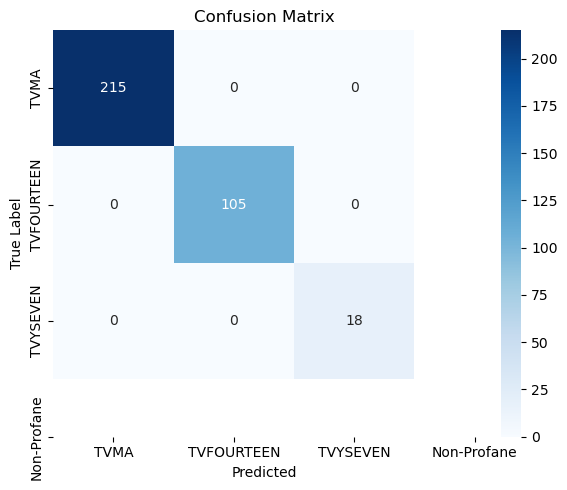

In [16]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[id_to_label[i] for i in range(len(label_to_id))],
            yticklabels=[id_to_label[i] for i in range(len(label_to_id))])
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB

#  Update to your path
model_path = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Tapad/best_astv2_wordlevelfinalonefolder.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval().to(device)

# Mel transforms
sample_rate = 16000
mel_transform = MelSpectrogram(sample_rate=sample_rate, n_fft=1024, hop_length=320, n_mels=128)
db_transform = AmplitudeToDB(top_db=80)

# Labels
label_to_id = {'TVMA': 0, 'TVFOURTEEN': 1, 'TVYSEVEN': 2, 'Non-Profane': 3}
id_to_label = {v: k for k, v in label_to_id.items()}


In [18]:
def predict_on_audio(file_path, model, mel_transform, db_transform, device,
                     window_sec=1.0, stride_sec=0.5, threshold=0.5):
    waveform, sr = torchaudio.load(file_path)
    waveform = torchaudio.functional.resample(waveform, sr, sample_rate)
    waveform = waveform.mean(dim=0, keepdim=True)  # mono

    window_samples = int(window_sec * sample_rate)
    stride_samples = int(stride_sec * sample_rate)
    total_samples = waveform.shape[1]

    predictions, confidences, segments = [], [], []

    for start in range(0, total_samples - window_samples + 1, stride_samples):
        end = start + window_samples
        segment = waveform[:, start:end]

        with torch.no_grad():
            mel = mel_transform(segment)
            mel_db = db_transform(mel)
            mel_db = mel_db.unsqueeze(0)  # [1, 1, H, W]

            if mel_db.shape[-1] < 10:
                predictions.append(None)
                confidences.append(None)
                segments.append((start, end))
                continue

            mel_resized = torch.nn.functional.interpolate(mel_db, size=(224, 224), mode='bilinear', align_corners=False)
            output = model(mel_resized.to(device))
            probs = torch.softmax(output, dim=1).cpu().squeeze()
            conf, pred = torch.max(probs, dim=0)

            predictions.append(pred.item() if conf >= threshold else None)
            confidences.append(conf.item() if conf >= threshold else None)
            segments.append((start, end))

    return waveform.squeeze().numpy(), segments, predictions, confidences


In [19]:
import matplotlib.pyplot as plt
from IPython.display import Audio

def plot_predictions(waveform_np, segments, predictions, confidences, sr=sample_rate):
    plt.figure(figsize=(14, 4))
    plt.plot(waveform_np, alpha=0.7)
    
    for (start, end), label_id, conf in zip(segments, predictions, confidences):
        if label_id is not None:
            label = id_to_label[label_id]
            plt.axvspan(start, end, color='red', alpha=0.2)
            plt.text((start + end) // 2, 0.5, f"{label}\n({conf:.2f})",
                     color='red', fontsize=10, rotation=90, ha='center', va='bottom')
    
    plt.title("Predicted Labels per Segment (with Confidence)")
    plt.xlabel("Sample index")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.grid(True)
    plt.show()


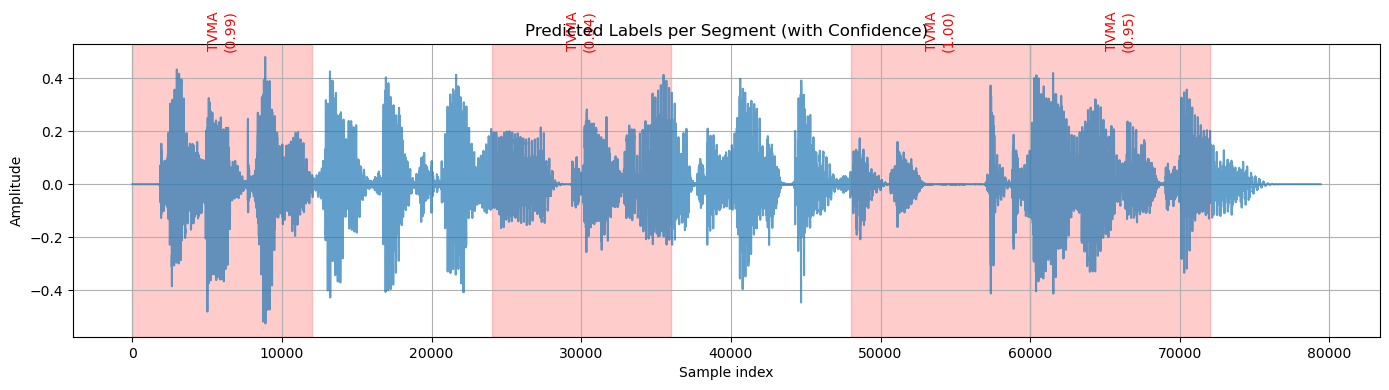

In [ ]:
#  Replace with your test file path
audio_path = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/newdata/new/line_1221.mp3"

# audio_path = "/Users/raj/University/AVS 8/AVS8_AAU_Audio_Main/Synthetic Audio/Syn_Aud_categorized/non_profane/3174_non_profane.mp3"

waveform_np, segments, predictions, confidences = predict_on_audio(
    audio_path, model, mel_transform, db_transform, device,
    window_sec=.75, stride_sec=0.75, threshold=.9
)

plot_predictions(waveform_np, segments, predictions, confidences)
Audio(audio_path)


In [44]:
import numpy as np

def apply_beep_on_predictions(waveform, sample_rate, segments, predictions, labels_to_beep, beep_freq=1000, gain_db=-5):
    waveform = waveform.clone() if torch.is_tensor(waveform) else torch.tensor(waveform).unsqueeze(0)

    # Create a simple sine wave beep of 1 sec
    beep = torch.sin(2 * np.pi * beep_freq * torch.arange(0, 1.0, 1.0 / sample_rate))
    beep = beep.unsqueeze(0)  # [1, time]
    beep = beep * (10 ** (gain_db / 20))  # Adjust gain

    for (start, end), label_id in zip(segments, predictions):
        if label_id is None:
            continue

        label = id_to_label[label_id]
        if label not in labels_to_beep:
            continue

        # Convert sample indices
        duration = end - start
        beep_resized = torch.nn.functional.interpolate(beep.unsqueeze(0), size=duration, mode='linear').squeeze(0)

        # Apply the beep
        waveform[:, start:end] = beep_resized[:, :duration]

    return waveform


In [ ]:
labels_to_beep = ["TVMA", "TVFOURTEEN", "TVYSEVEN"]  # You can adjust this
waveform_tensor = torch.tensor(waveform_np).unsqueeze(0)

beeped_waveform = apply_beep_on_predictions(waveform_tensor, sample_rate, segments, predictions, labels_to_beep)

# Save it if you want
output_path = "beeped_output123.wav"
torchaudio.save(output_path, beeped_waveform, sample_rate)
print(f"Saved to: {output_path}")

# Play it in notebook
from IPython.display import Audio
Audio(output_path)


✅ Saved to: beeped_output123.wav
